Velg datasett (plateau / gaussian / sinusoidal):


>>  gaussian


Episode 1, Total Loss: 4.9929


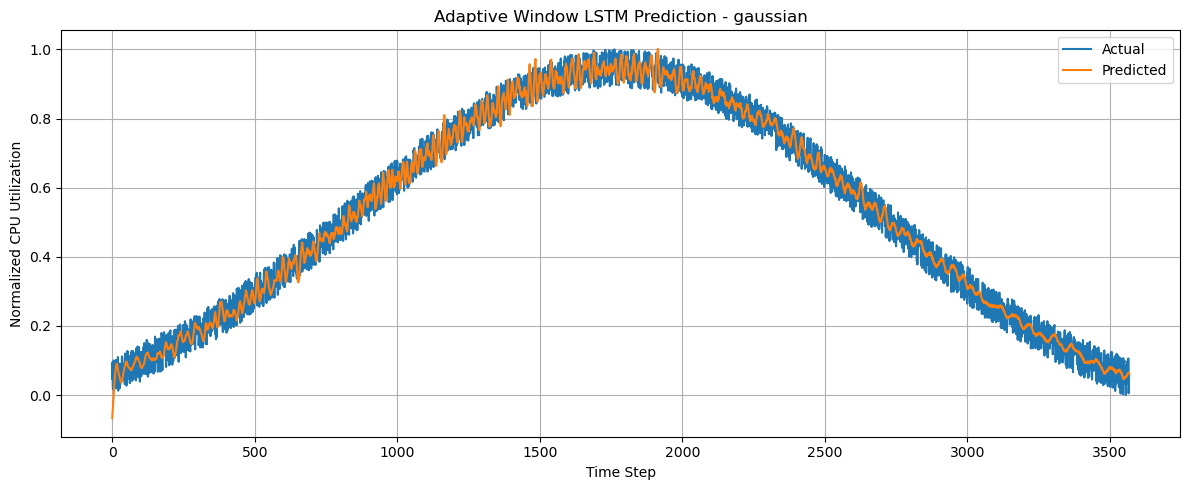

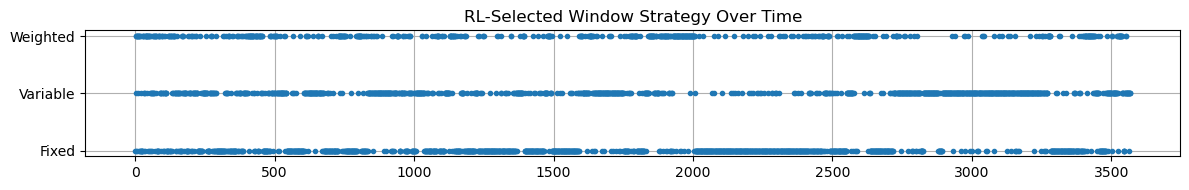

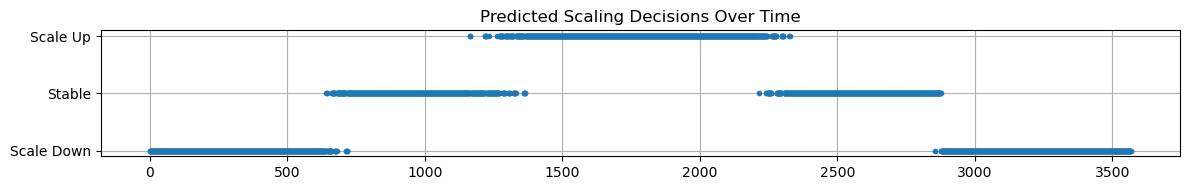

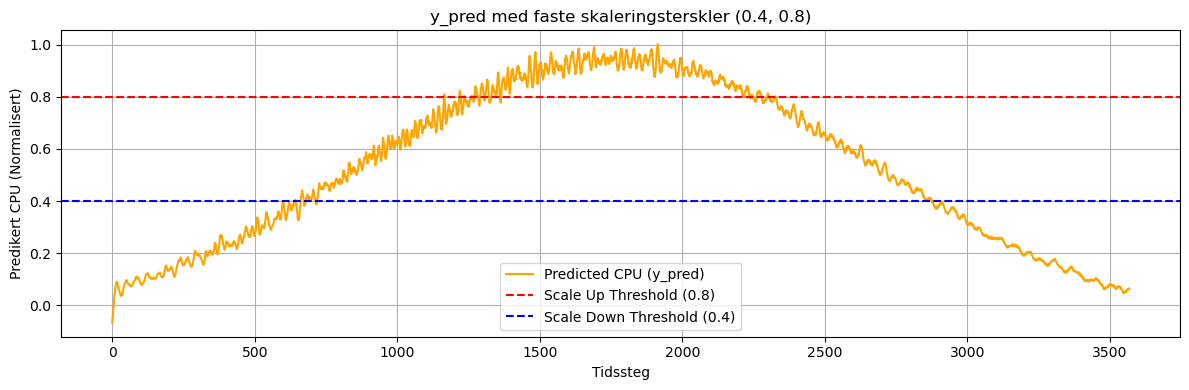

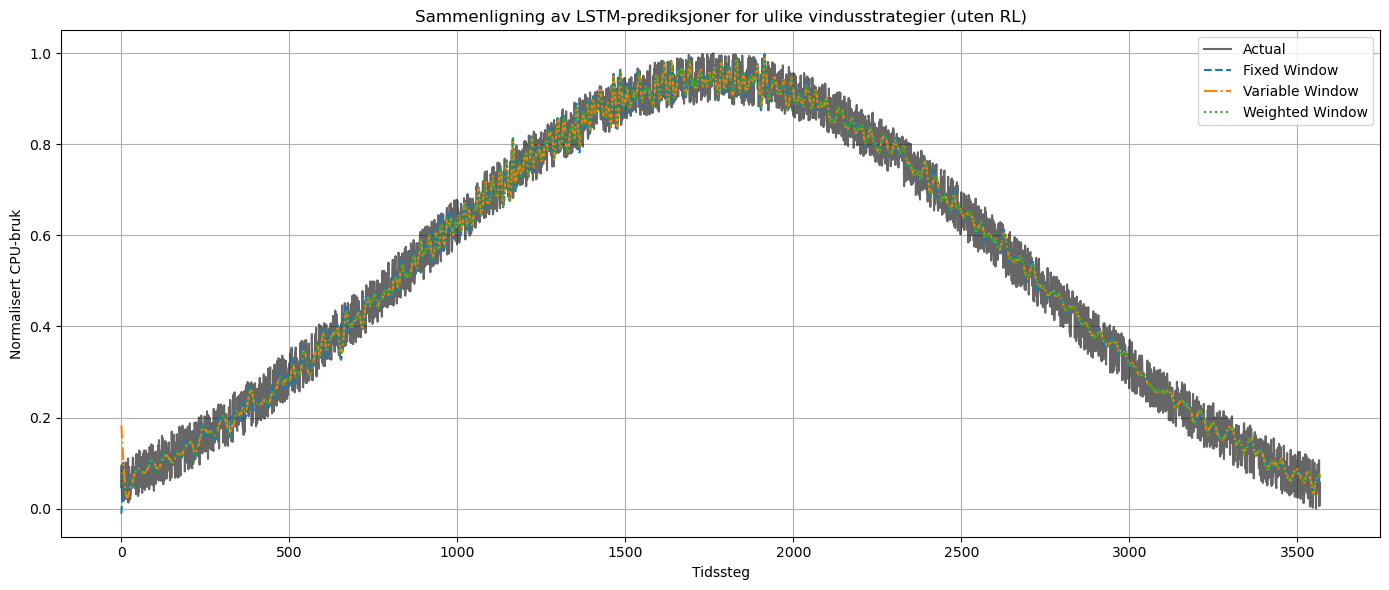

Antall prediksjoner: 3569
Antall rader i datasett: 3600


In [114]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

print("Velg datasett (plateau / gaussian / sinusoidal):")
choice = input(">> ").strip().lower()

file_map = {
    "plateau": "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/Newest addition/Plateu/plateau_log.csv",
    "gaussian": "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/Newest addition/Gausian curve/gaussian_curve_fixed.csv",
    "sinusoidal": "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/Newest addition/sinusoid curve/sinusoidal_log.csv"
}

if choice not in file_map:
    print("Ugyldig valg.")
    exit()

filename = file_map[choice]
if not os.path.exists(filename):
    print(f"Filen '{filename}' ble ikke funnet i mappen.")
    exit()

df = pd.read_csv(filename)
scaler = MinMaxScaler()
normalized = scaler.fit_transform(df[['Y']].values).astype(np.float32)

def fixed_window(data, idx, size=20):
    if idx < size: return data[0:idx+1]
    return data[idx-size+1:idx+1]

def variable_window(data, idx, min_size=10, max_size=30):
    size = random.randint(min_size, max_size)
    if idx < size: return data[0:idx+1]
    return data[idx-size+1:idx+1]

def weighted_window(data, idx, size=20):
    if idx < size:
        window = data[0:idx+1]
    else:
        window = data[idx-size+1:idx+1]
    weights = np.linspace(0.1, 1.0, len(window)).reshape(-1, 1)
    return window * weights

class LSTMModel(nn.Module): 
    def __init__(self, input_size=1, hidden_size=64):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

model = LSTMModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

Q = np.zeros((3,))
epsilon = 0.2
alpha = 0.1
gamma = 0.9

episodes = 1
predictions, actuals, actions_taken, scale_decisions = [], [], [], []

low_thresh = 0.4
high_thresh = 0.8

for ep in range(episodes):
    total_loss = 0
    for t in range(30, len(normalized)-1):
        if random.random() < epsilon:
            action = random.randint(0, 2)
        else:
            action = int(np.argmax(Q))

        if action == 0:
            window = fixed_window(normalized, t)
        elif action == 1:
            window = variable_window(normalized, t)
        else:
            window = weighted_window(normalized, t)

        x = torch.tensor(window, dtype=torch.float32)
        if x.ndim == 1:
            x = x.unsqueeze(0).unsqueeze(-1)
        elif x.ndim == 2:
            x = x.unsqueeze(0)

        y_true = torch.tensor(normalized[t+1], dtype=torch.float32).unsqueeze(0)
        y_pred = model(x)
        loss = loss_fn(y_pred, y_true)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        reward = -loss.item()
        Q[action] = Q[action] + alpha * (reward + gamma * np.max(Q) - Q[action])

        predictions.append(y_pred.item())
        actuals.append(y_true.item())
        actions_taken.append(action)

        if y_pred.item() > high_thresh:
            scale_decisions.append(1)
        elif y_pred.item() < low_thresh:
            scale_decisions.append(-1)
        else:
            scale_decisions.append(0)

    print(f"Episode {ep+1}, Total Loss: {total_loss:.4f}")

# === RL-baserte grafer ===
plt.figure(figsize=(12, 5))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title(f"Adaptive Window LSTM Prediction - {choice}")
plt.xlabel("Time Step")
plt.ylabel("Normalized CPU Utilization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2))
plt.plot(actions_taken, '.', label='Action (0=Fixed, 1=Variable, 2=Weighted)')
plt.yticks([0, 1, 2], ['Fixed', 'Variable', 'Weighted'])
plt.title("RL-Selected Window Strategy Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2))
plt.plot(scale_decisions, '.', label='Scaling Action')
plt.yticks([-1, 0, 1], ['Scale Down', 'Stable', 'Scale Up'])
plt.title("Predicted Scaling Decisions Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(predictions, label='Predicted CPU (y_pred)', color='orange')
plt.axhline(y=high_thresh, color='red', linestyle='--', label='Scale Up Threshold (0.8)')
plt.axhline(y=low_thresh, color='blue', linestyle='--', label='Scale Down Threshold (0.4)')
plt.title("y_pred med faste skaleringsterskler (0.4, 0.8)")
plt.xlabel("Tidssteg")
plt.ylabel("Predikert CPU (Normalisert)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Statisk evaluering av hver enkelt sliding window-type (uten RL) ===
def run_static_strategy(strategy_func, label):
    model_static = LSTMModel()
    optimizer_static = torch.optim.Adam(model_static.parameters(), lr=0.001)
    predictions_static, actuals_static = [], []
    loss_fn_static = nn.MSELoss()

    for t in range(30, len(normalized) - 1):
        window = strategy_func(normalized, t)

        x = torch.tensor(window, dtype=torch.float32)
        if x.ndim == 1:
            x = x.unsqueeze(0).unsqueeze(-1)
        elif x.ndim == 2:
            x = x.unsqueeze(0)

        y_true = torch.tensor(normalized[t + 1], dtype=torch.float32).unsqueeze(0)
        y_pred = model_static(x)

        loss = loss_fn_static(y_pred, y_true)

        optimizer_static.zero_grad()
        loss.backward()
        optimizer_static.step()

        predictions_static.append(y_pred.item())
        actuals_static.append(y_true.item())

    return predictions_static, actuals_static

# === Kjør hver strategi separat ===
pred_fixed, actual_fixed = run_static_strategy(fixed_window, "Fixed")
pred_variable, actual_variable = run_static_strategy(variable_window, "Variable")
pred_weighted, actual_weighted = run_static_strategy(weighted_window, "Weighted")

# === Felles sammenligningsgraf ===
plt.figure(figsize=(14, 6))
plt.plot(actual_fixed, label='Actual', color='black', linewidth=1.5, alpha=0.6)
plt.plot(pred_fixed, label='Fixed Window', linestyle='--')
plt.plot(pred_variable, label='Variable Window', linestyle='-.')
plt.plot(pred_weighted, label='Weighted Window', linestyle=':')
plt.title("Sammenligning av LSTM-prediksjoner for ulike vindusstrategier (uten RL)")
plt.xlabel("Tidssteg")
plt.ylabel("Normalisert CPU-bruk")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Antall prediksjoner:", len(pred_fixed))
print("Antall rader i datasett:", len(normalized))


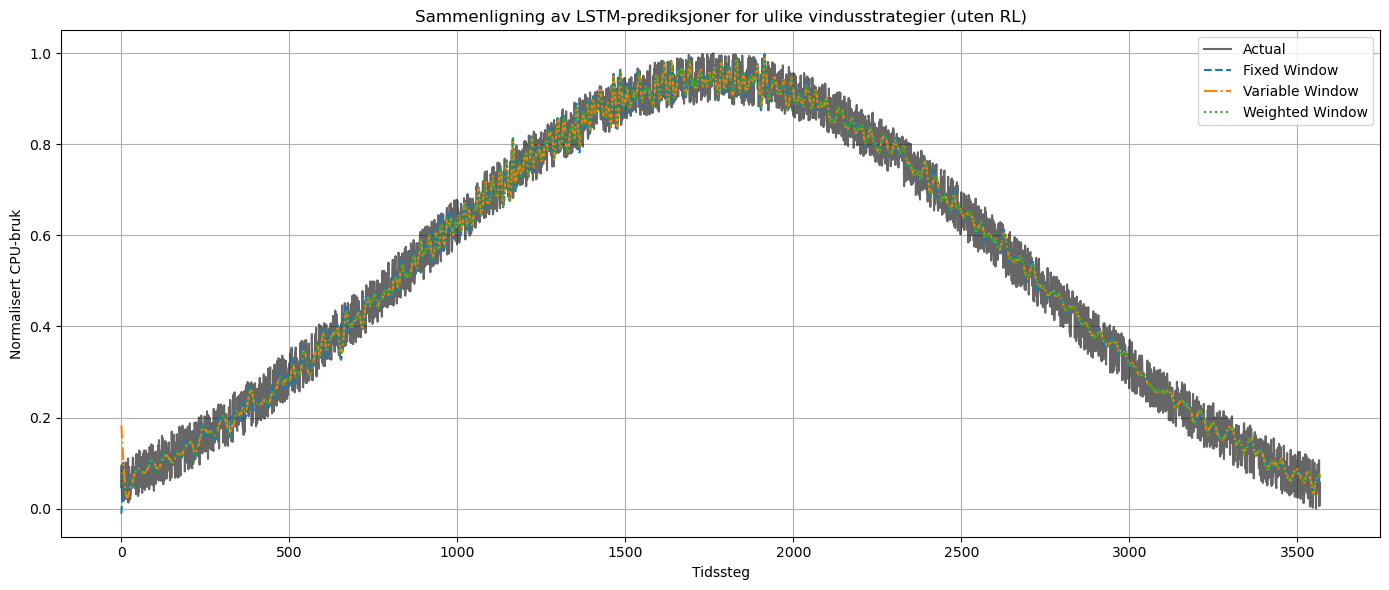

In [115]:
# === Felles sammenligningsgraf ===
plt.figure(figsize=(14, 6))
plt.plot(actual_fixed, label='Actual', color='black', linewidth=1.5, alpha=0.6)
plt.plot(pred_fixed, label='Fixed Window', linestyle='--')
plt.plot(pred_variable, label='Variable Window', linestyle='-.')
plt.plot(pred_weighted, label='Weighted Window', linestyle=':')
plt.title("Sammenligning av LSTM-prediksjoner for ulike vindusstrategier (uten RL)")
plt.xlabel("Tidssteg")
plt.ylabel("Normalisert CPU-bruk")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

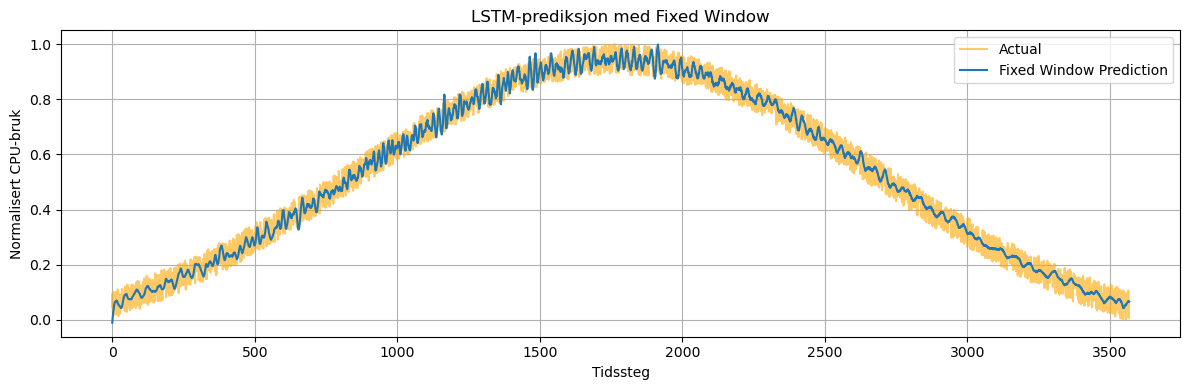

In [116]:
# === Separat graf for Fixed Window ===
plt.figure(figsize=(12, 4))
plt.plot(actual_fixed, label='Actual', color='orange', linewidth=1.5, alpha=0.6)
plt.plot(pred_fixed, label='Fixed Window Prediction', linestyle='-')
plt.title("LSTM-prediksjon med Fixed Window")
plt.xlabel("Tidssteg")
plt.ylabel("Normalisert CPU-bruk")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


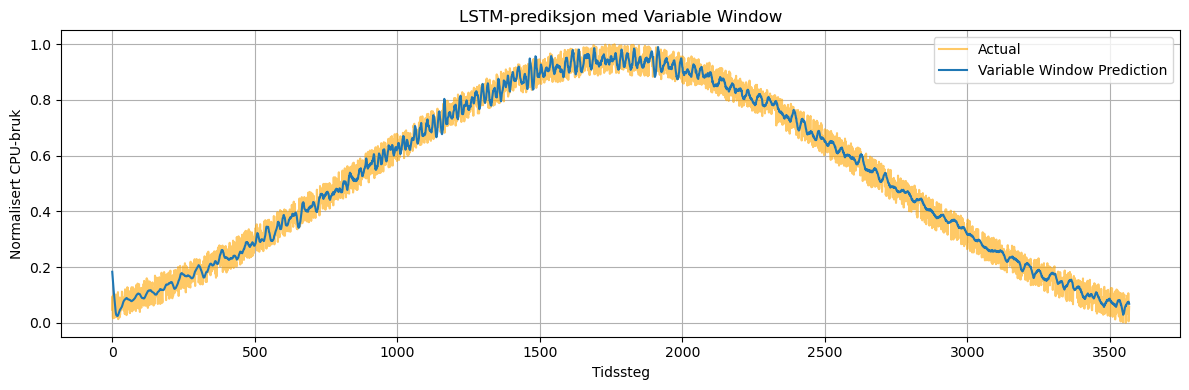

In [117]:
# === Separat graf for Variable Window ===
plt.figure(figsize=(12, 4))
plt.plot(actual_variable, label='Actual', color='orange', linewidth=1.5, alpha=0.6)
plt.plot(pred_variable, label='Variable Window Prediction', linestyle='-')
plt.title("LSTM-prediksjon med Variable Window")
plt.xlabel("Tidssteg")
plt.ylabel("Normalisert CPU-bruk")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


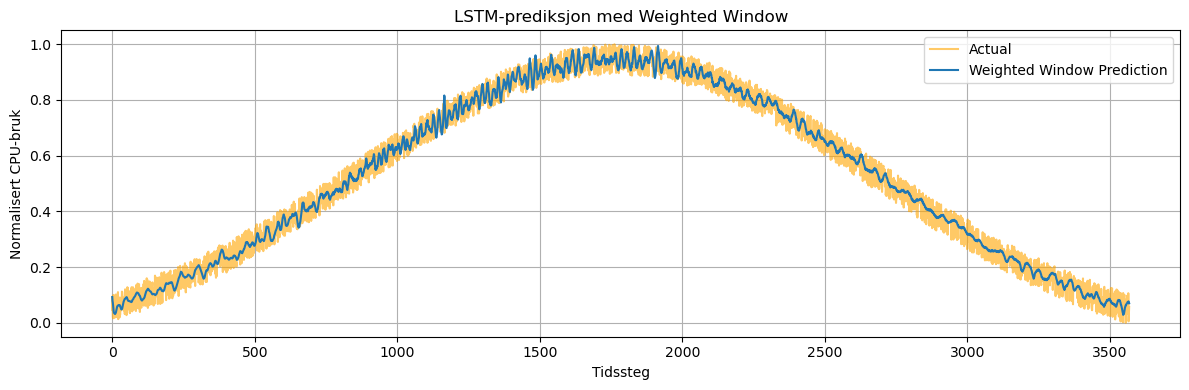

In [118]:
# === Separat graf for Weighted Window ===
plt.figure(figsize=(12, 4))
plt.plot(actual_weighted, label='Actual', color='orange', linewidth=1.5, alpha=0.6)
plt.plot(pred_weighted, label='Weighted Window Prediction', linestyle='-')
plt.title("LSTM-prediksjon med Weighted Window")
plt.xlabel("Tidssteg")
plt.ylabel("Normalisert CPU-bruk")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [108]:
#EXPORTS
# === Funksjon for å eksportere prediksjonsdata ===
#def export_to_txt(filename, actual, predicted):
    data = np.column_stack((np.arange(len(actual)), actual, predicted))
    np.savetxt(filename, data, fmt="%.5f", delimiter="\t", header="x\tactual\tpredicted", comments='')

# === Eksporter RL-prediksjoner ===
#export_to_txt("rl_predictions.txt", actuals, predictions)

# === Eksporter statiske strategier ===
#export_to_txt("fixed_predictions.txt", actual_fixed, pred_fixed)
#export_to_txt("variable_predictions.txt", actual_variable, pred_variable)
#export_to_txt("weighted_predictions.txt", actual_weighted, pred_weighted)

# === Eksporter RL-strategivalg (0=fixed, 1=variable, 2=weighted) ===
#actions_data = np.column_stack((np.arange(len(actions_taken)), actions_taken))
#np.savetxt("rl_actions.txt", actions_data, fmt="%.0f", delimiter="\t", header="x\taction", comments='')

# === Eksporter skaleringsbeslutninger (-1, 0, 1) ===
#scale_data = np.column_stack((np.arange(len(scale_decisions)), scale_decisions))
#np.savetxt("rl_scaling.txt", scale_data, fmt="%.0f", delimiter="\t", header="x\tscale", comments='')

# === Eksporter y_pred for terskel-plotting ===
#threshold_data = np.column_stack((np.arange(len(predictions)), predictions))
#np.savetxt("rl_y_pred.txt", threshold_data, fmt="%.5f", delimiter="\t", header="x\ty_pred", comments='')

#print("✅ Alle .txt-filer generert! Last opp i Overleaf og bruk med PGFPlots 🎯")


✅ Alle .txt-filer generert! Last opp i Overleaf og bruk med PGFPlots 🎯


Antall prediksjoner: 969
Antall rader i datasett: 1000
